In [1]:
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
from torch.utils.data import TensorDataset, DataLoader, random_split
import os

try:
  from google.colab import drive
  IN_COLAB = True
  drive.mount('/content/drive')
except:
  IN_COLAB = False


Mounted at /content/drive


In [2]:
if IN_COLAB:
    data_path = "/content/drive/MyDrive/Colab Notebooks/dataset/ko2eng"
else:
    data_path = "dataset/ko2eng"

x = np.array([])
y = np.array([])

for fname in sorted(os.listdir(data_path)):
    src_input_ids = os.path.join(data_path, fname)
    df = pd.read_excel(src_input_ids)
    x = np.concatenate((x, df['원문'].values))
    y = np.concatenate((y, df['번역문'].values))

print(x.shape)
print(y.shape)

(801387,)
(801387,)


In [3]:
x_len_array = [len(sentence) for sentence in x]
y_len_array = [len(sentence) for sentence in y]

unique_x, counts_x = np.unique(x_len_array, return_counts=True)
freq_x = np.column_stack((unique_x, counts_x))
sorted_freq_x = freq_x[freq_x[:, 1].argsort()[::-1]]

unique_y, counts_y = np.unique(y_len_array, return_counts=True)
freq_y = np.column_stack((unique_y, counts_y))
sorted_freq_y = freq_y[freq_y[:, 1].argsort()[::-1]]

print("x max:", np.max(x_len_array))
print("x mean:", np.mean(x_len_array))
print("x median:", np.median(x_len_array))
print("freq top 5:", sorted_freq_x[:5])

print("y max:", np.max(y_len_array))
print("y mean:", np.mean(y_len_array))
print("y median:", np.median(y_len_array))
print("freq top 5:", sorted_freq_y[:5])

x max: 220
x mean: 69.15487149155152
x median: 71.0
freq top 5: [[   70 18371]
 [   68 18287]
 [   69 18245]
 [   71 18199]
 [   73 17843]]
y max: 706
y mean: 173.24487170368374
y median: 174.0
freq top 5: [[ 171 5306]
 [ 179 5263]
 [ 181 5254]
 [ 175 5238]
 [ 183 5222]]


In [4]:
y_len_np = np.array(y_len_array)
x_len_np = np.array(x_len_array)

max_len_condition = 100
condition = (y_len_np < max_len_condition) & (x_len_np < max_len_condition)
print(f"y_{max_len_condition} max:", np.max(y_len_np[condition]))
print(f"x_{max_len_condition} max:", np.max(x_len_np[condition]))

x_max_condition = x[condition]
y_max_condition = y[condition]

print(x_max_condition)
print(y_max_condition)
print(len(x_max_condition))
print(len(y_max_condition))


y_100 max: 99
x_100 max: 98
['스키너가 말한 보상은 대부분 눈으로 볼 수 있는 현물이다.' '심지어 어떤 문제가 발생할 건지도 어느 정도 예측이 가능하다.'
 '오직 하나님만이 그 이유를 제대로 알 수 있을 겁니다.' ...
 '그물추는 그물이 물속에 쉽게 가라앉도록 그물 끝에 매다는 돌이다.'
 '우리가 하고 싶은 것을 다하면, 능력에서 좋은 선수들이 많으니 잘 할 수 있도록 도와줄 것이다.'
 '조금이라도 더 알려고, 조금이라도 더 느끼려고 다가가는 발걸음이 지금 우리가 할 수 있는 최선인 셈이다.']
["Skinner's reward is mostly eye-watering."
 'Even some problems can be predicted.' 'Only God will exactly know why.'
 ...
 'Net lead is a stone that hangs at the end of a net so that the net can sink easily in the water.'
 'If we do what we want to do, there are a lot of good players in that we will help them do well.'
 'The best thing we can do now is to trying get to know a little bit more and feel a little bit more.']
138934
138934


In [5]:
from tokenizers import Tokenizer, decoders, models, normalizers, pre_tokenizers, trainers, processors


def train_tokenizer(src, vocab_size, special_token, max_len, padding=False):
    tokenizer = Tokenizer(models.WordPiece())
    tokenizer.normalizer = normalizers.NFKC()
    tokenizer.pre_tokenizer = pre_tokenizers.Whitespace()
    tokenizer.decoder = decoders.WordPiece()
    token_trainer = trainers.WordPieceTrainer(
        vocab_size = vocab_size,
        special_tokens=special_token,
        show_progress=True,
    )

    tokenizer.train_from_iterator(src, trainer=token_trainer)
    tokenizer.enable_truncation(max_len)
    if padding:
        tokenizer.enable_padding(length=max_len)

    return tokenizer



# ["[PAD]", "[UNK]", "[BOS]", "[EOS]"]
vocab_size = 10000
special_token = ["[PAD]", "[UNK]", "[BOS]", "[EOS]"]
max_len = max_len_condition
src_tokenizer = train_tokenizer(x_max_condition, vocab_size, special_token, max_len, True)
tgt_tokenizer = train_tokenizer(y_max_condition, vocab_size, special_token, max_len)

print(x_max_condition[0])
temp = src_tokenizer.encode(x_max_condition[0])
print(temp.tokens)
print(temp.ids)
print(src_tokenizer.decode(temp.ids))

print(y_max_condition[0])
temp = tgt_tokenizer.encode(y_max_condition[0])
print(temp.tokens)
print(temp.ids)
print(tgt_tokenizer.decode(temp.ids))

스키너가 말한 보상은 대부분 눈으로 볼 수 있는 현물이다.
['스', '##키', '##너', '##가', '말한', '보상', '##은', '대부분', '눈', '##으로', '볼', '수', '있는', '현', '##물이', '##다', '.', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]']
[1047, 2014, 2247, 1862, 9512, 9307, 1904, 3813, 414, 3415, 859, 1019, 3428, 1767, 3752, 1838, 14, 0, 0, 0, 0, 0,

In [6]:
def get_decoder_data(tokenizer, entry, max_len, eos_token=True, bos_token=False):

    tokens = tokenizer.encode(entry).ids
    if eos_token:
        tokens.append(3) # 3:'[EOS]'
    if bos_token:
        tokens.insert(0, 2) # 2:'[BOS]'
    tokens.extend((max_len - len(tokens))*[0])
    return tokens


print(get_decoder_data(tgt_tokenizer, y_max_condition[0], max_len, True, True))

[2, 53, 7472, 156, 1268, 10, 84, 6416, 286, 4822, 2081, 16, 1397, 283, 17, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [7]:
encoder_input_ids = torch.tensor(np.array([src_tokenizer.encode(entry).ids for entry in x_max_condition]))
decoder_input_ids = torch.tensor(np.array([get_decoder_data(tgt_tokenizer, entry, max_len, True, True) for entry in y_max_condition]))
decoder_target_ids = torch.tensor(np.array([get_decoder_data(tgt_tokenizer, entry, max_len, True, False) for entry in y_max_condition]))

dataset = TensorDataset(encoder_input_ids, decoder_input_ids, decoder_target_ids)
train_dataset, val_dataset, test_dataset = random_split(dataset=dataset, lengths=[0.7, 0.15, 0.15])

In [8]:
batch_size = 64
train_dl = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dl = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_dl = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [9]:
import math

class TransformerModel(nn.Module):
    def __init__(self, config) -> None:
        super().__init__()
        self.d_model = config['d_model'] if 'd_model' in config else 512
        self.n_head = config['n_head'] if 'n_head' in config else 8
        self.n_encoder = config['n_encoder'] if 'n_encoder' in config else 6
        self.n_decoder = config['n_decoder'] if 'n_decoder' in config else 6
        self.hidden_size = config['hidden_size'] if 'hidden_size' in config else 512
        self.seq_len = config['seq_len']
        self.device = config['device']

        self.src_embed = nn.Embedding(config['src_vocab_size'], embedding_dim=self.d_model)
        self.tgt_embed = nn.Embedding(config['tgt_vocab_size'], embedding_dim=self.d_model)


        self.pos_embed = PositionalEncoding(d_model=self.d_model, device=self.device)
        self.padding_mask = PaddingMask(pad_id=config['pad_id'])

        self.transformer = nn.Transformer(
            d_model=self.d_model,
            nhead=self.n_head,
            num_encoder_layers=self.n_encoder,
            num_decoder_layers=self.n_decoder,
        )

        # tgt_mask : [dec_seq, dec_seq] : 출력 Sequence Attention Mask (Trm decoding을 위한 계단식 MASK)
        # tgt_mask 입력 길이 L에 대한 (L X L) mask 생성. torch.triu 사용. (생성된 값만 보게끔 하는 부분)
        self.tgt_mask = torch.triu(torch.ones(self.seq_len, self.seq_len), diagonal=1).bool().to(self.device)

        self.projection_layer_1 = nn.Linear(self.d_model, self.hidden_size)
        self.activation = nn.GELU()
        self.projection_layer_2 = nn.Linear(self.hidden_size, config['tgt_vocab_size'])


    def forward(self, src_input_ids, tgt_input_ids,
                src_key_padding_mask = None, tgt_key_padding_mask = None):

        # src_input_ids: (batch, seq_len)
        # target_input_ids: (batch, seq_len)

        encoder_input_feature = self.src_embed(src_input_ids)
        # encoder_input_feuatre: (batch, seq_len, embedding)
        encoder_input_feature = encoder_input_feature.transpose(0, 1)
        # pos_embed worked based on seq_len, batch, embeding
        encoder_input_feature = self.pos_embed(encoder_input_feature)

        # same as encoder input handling
        decoder_input_feature = self.tgt_embed(tgt_input_ids)
        decoder_input_feature = decoder_input_feature.transpose(0, 1)
        decoder_input_feature = self.pos_embed(decoder_input_feature)

        # src : [enc_seq, batch, hidden]
        # tgt : [dec_seq, batch, hidden]

        # src_mask : [enc_seq, enc_seq] : 입력 Sequence Attention Mask (일반적으로 사용하지 않음)


        # src_key_padding_mask : [batch, enc_seq] : 입력 Padding Mask
        src_key_padding_mask = self.padding_mask(src_input_ids)

        # tgt_key_padding_mask : [batch, dec_seq] : 출력 Padding Mask
        tgt_key_padding_mask = self.padding_mask(tgt_input_ids)

        # src_mask는 일반적으로 구현 x
        # src_key_padding_mask : masked_fill 이용해서 생성
        # tgt_key_padding_mask

        out = self.transformer(encoder_input_feature, decoder_input_feature,
                               src_mask=None, tgt_mask=self.tgt_mask,
                               src_key_padding_mask=src_key_padding_mask,
                               tgt_key_padding_mask=tgt_key_padding_mask,)

        out = self.projection_layer_1(out)
        out = self.activation(out)
        out = self.projection_layer_2(out)

        return out

class PositionalEncoding(nn.Module):
    def __init__(self, d_model, device, dropout: float = 0.1, max_len: int = 5000) -> None:
        super().__init__()
        self.d_model = d_model
        self.dropout = nn.Dropout(p=dropout)

        position = torch.arange(max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model))
        pe = torch.zeros(max_len, 1, d_model)
        pe[:, 0, 0::2] = torch.sin(position * div_term)
        pe[:, 0, 1::2] = torch.cos(position * div_term)
        pe = pe.to(device)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:x.size(0)]
        return self.dropout(x)

class PaddingMask(nn.Module):
    def __init__(self, pad_id) -> None:
        super().__init__()
        self.pad_id = pad_id

    def forward(self, x):
        return x.masked_fill(x == self.pad_id, 1).masked_fill(x != self.pad_id, 0).bool()


In [10]:
import io
from tqdm import tqdm

class Trainer():
    def __init__(self, config, model, train_dl, val_dl, test_dl, criterion, optimizer, src_tokenizer, tgt_tokenizer) -> None:
        self.model_name = model.__class__.__name__
        self.config = config
        self.model = model
        self.train_dl = train_dl
        self.val_dl = val_dl
        self.test_dl = test_dl
        self.criterion = criterion
        self.optimizer = optimizer

        self.device = config['device'] if 'device' in config else "cpu"
        self.num_of_epoch = config['epoch'] if 'epoch' in config else 10
        self.lr = config['learning_rate'] if 'learning_rate' in config else 1e-2
        self.patience = config['patience'] if 'patience' in config else 5
        self.output_dir = config['output'] if 'output' in config else "output/"
        self.src_tokenizer = src_tokenizer
        self.tgt_tokenizer = tgt_tokenizer
        self.seq_len = config['seq_len']

    def train(self):
        train_loss_history = []
        val_loss_history = []

        self.model = self.model.to(self.device)
        best_epoch = 0
        best_loss = np.inf
        epochs_no_improve = 0
        buffer = io.BytesIO()


        for epoch in range(self.num_of_epoch):
            self.model.train()
            epoch_loss = 0
            total_count = 0
            pbar = tqdm(self.train_dl, desc=f"epoch[{epoch+1}]")

            for step, batch in enumerate(pbar):
                encoder_input_ids = batch[0].to(self.device)
                decoder_input_ids = batch[1].to(self.device)
                decoder_target_ids = batch[2].to(self.device)

                self.optimizer.zero_grad()
                pred = self.model(encoder_input_ids, decoder_input_ids)

                # y_pred ( seq_len, batch, feature_num )
                pred_compare = torch.reshape(pred, (-1, pred.shape[-1]))
                # y ( batch, seq_len )
                target = decoder_target_ids.transpose(0, 1)
                target = torch.reshape(target, (-1,))

                loss = self.criterion(pred_compare, target)
                epoch_loss += loss.item() * target.shape[0]
                loss.backward()
                self.optimizer.step()

                total_count += target.shape[0]
                pbar.set_postfix_str(f"loss={loss.item():.5f}")

            epoch_loss_mean = epoch_loss / total_count
            val_loss_mean = self.validation()


            train_loss_history.append(epoch_loss_mean)
            val_loss_history.append(val_loss_mean)

            if val_loss_mean < best_loss:
                best_loss = val_loss_mean
                epochs_no_improve = 0

                buffer.seek(0)
                buffer.truncate()
                torch.save(self.model.state_dict(), buffer)
                buffer.seek(0)
            else:
                epochs_no_improve += 1

            if epochs_no_improve >= self.patience:
                print(f'Early stopping at epoch {epoch}')
                break

            output_path = os.path.join(self.output_dir, f"{self.model_name}_ep_{epoch}_loss_{epoch_loss_mean:.4f}_lr_{self.config['learning_rate']}.pt")
            print(output_path)
            torch.save(self.model.state_dict(), output_path)
            with open(output_path, mode='wb') as f:
                f.write(buffer.getbuffer())

        return (train_loss_history, val_loss_history), output_path

    def validation(self):
        self.model.eval()
        epoch_loss = 0
        total_count = 0
        pbar = tqdm(self.val_dl, desc=f"validation ")
        with torch.no_grad():
            for step, batch in enumerate(pbar):
                encoder_input_ids = batch[0].to(self.device)
                decoder_input_ids = batch[1].to(self.device)
                decoder_target_ids = batch[2].to(self.device)

                pred = self.model(encoder_input_ids, decoder_input_ids)
                # pred ( seq_len, batch, feature_num )
                pred_compare = torch.reshape(pred, (-1, pred.shape[-1]))
                # target ( batch, seq_len )
                target = decoder_target_ids.transpose(0, 1)
                target = torch.reshape(target, (-1,))

                loss = self.criterion(pred_compare, target)
                epoch_loss += loss.item() * target.shape[0]
                total_count += target.shape[0]

                if step % 100 == 0:
                    decoder_input_ids = torch.zeros(encoder_input_ids.shape).long()
                    decoder_input_ids[:,0] = self.tgt_tokenizer.token_to_id("[BOS]")
                    decoder_input_ids = decoder_input_ids.to(self.device)

                    encoder_input_id = encoder_input_ids[0].unsqueeze(0)
                    decoder_input_id = decoder_input_ids[0].unsqueeze(0)
                    for i in range(self.seq_len -1):
                        pred = self.model(encoder_input_id, decoder_input_id)
                        # pred (seq_len, batch, feature_num )
                        pred = torch.argmax(pred, dim=-1)
                        pred = pred.transpose(0, 1)
                        # pred (batch, seq_len)
                        decoder_input_id[:,i+1] = pred[:,i]
                        if pred[0,i] == self.tgt_tokenizer.token_to_id('[EOS]'):
                            break
                    print()
                    print("== inference check ==")
                    print("target :", self.tgt_tokenizer.decode(decoder_target_ids[0].detach().cpu().numpy()))
                    print("inference result:", self.tgt_tokenizer.decode(decoder_input_id[0].detach().cpu().numpy()))

        epoch_loss_mean = epoch_loss / total_count
        return epoch_loss_mean

    def test(self):
        self.model.eval()
        pbar = tqdm(self.val_dl, desc=f"test ")
        with torch.no_grad():
            for step, batch in enumerate(pbar):
                encoder_input_ids = batch[0].to(self.device)
                # decoder_input_ids = batch[1].to(self.device)
                decoder_target_ids = batch[2].to(self.device)
                decoder_input_ids = torch.zeros(encoder_input_ids.shape).long()
                decoder_input_ids[:,0] = self.tgt_tokenizer.token_to_id("[BOS]")
                decoder_input_ids = decoder_input_ids.to(self.device)

                for i in range(self.config['seq_len'] -1):
                    pred = self.model(encoder_input_ids, decoder_input_ids)
                    # pred (seq_len, batch, feature_num )
                    pred = torch.argmax(pred, dim=-1)
                    pred = pred.transpose(0, 1)
                    # pred (batch, seq_len)
                    decoder_input_ids[:,i+1] = pred[:,i]

                result = decoder_input_ids.detach().cpu().numpy()
                for i in range(result.shape[0]):
                    print()
                    print("input:", self.src_tokenizer.decode(encoder_input_ids[i].detach().cpu().numpy()))
                    print("target:", self.tgt_tokenizer.decode(decoder_target_ids[i].detach().cpu().numpy()))
                    print("inference:", self.tgt_tokenizer.decode(result[i]))
                break




In [11]:
import datetime

if IN_COLAB:
    output_base = "/content/drive/MyDrive/Colab Notebooks/results/transformer-ko2eng"
else:
    output_base = "output/transformer-ko2en"
current_date = datetime.datetime.now().strftime("%Y%m%d%H%M%S")
output_dir = os.path.join(output_base, current_date)
os.makedirs(output_dir, exist_ok=True)

config = {
    'batch_size':batch_size,
    'src_vocab_size':src_tokenizer.get_vocab_size(),
    'tgt_vocab_size':tgt_tokenizer.get_vocab_size(),
    'd_model':256,
    'n_head':4,
    'n_encoder':6,
    'n_decoder':6,
    'hidden_size':512,
    'pad_id':0,
    'dropout':0.1,
    'device': 'cuda' if torch.cuda.is_available() else "cpu",
    'epoch': 50,
    'learning_rate':1e-4,
    'seq_len':max_len,
    'output':output_dir
}

model = TransformerModel(config)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=0.01)
trainer = Trainer(config, model, train_dl, val_dl, test_dl, criterion, optimizer, src_tokenizer, tgt_tokenizer)


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:306: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


In [58]:
trainer = Trainer(config, model, train_dl, val_dl, test_dl, criterion, optimizer, src_tokenizer, tgt_tokenizer)
(train_loss_history, val_loss_history), output_path = trainer.train()

validation :   1%|          | 4/326 [00:00<00:33,  9.75it/s]


== inference check ==
target : Among them, in Seoul and Gyeonggi - do, automatically purchased consumers won.
inference result: The first time that the first time, the first time to be not been not been not been not been a lot.


validation :  32%|███▏      | 104/326 [00:06<00:17, 12.46it/s]


== inference check ==
target : In the afternoon, the North will be guided by the South to check the South ' s GP.
inference result: The first time that the first time, the first time to be not been a lot of the first time.


validation :  63%|██████▎   | 204/326 [00:11<00:10, 11.65it/s]


== inference check ==
target : When the way is blocked by camera, he starts to run out to the side.
inference result: The first time that the first time, the first time to be not been not been not been not been not been a lot.


validation :  93%|█████████▎| 304/326 [00:17<00:01, 12.27it/s]


== inference check ==
target : I had to walk and walk toward the starlight, looking for a star close to where I should walk.
inference result: The first time that the first time, the first time to be a good in the first time.


validation : 100%|██████████| 326/326 [00:18<00:00, 17.35it/s]


/content/drive/MyDrive/Colab Notebooks/results/transformer-ko2eng/20240801144040/TransformerModel_ep_0_loss_1.1900_lr_0.0001.pt


validation :   1%|          | 4/326 [00:01<01:05,  4.88it/s]


== inference check ==
target : Among them, in Seoul and Gyeonggi - do, automatically purchased consumers won.
inference result: The police has been held by the U. S. S. and the U. S. S. S. S. S. S. S. S. and the first. and the first. S. S. and the first. S. S. S. S. S. and the first. S. S. S. S.


validation :  32%|███▏      | 104/326 [00:06<00:17, 12.95it/s]


== inference check ==
target : In the afternoon, the North will be guided by the South to check the South ' s GP.
inference result: The first time that the police was held by the first time, and the police was held.


validation :  63%|██████▎   | 204/326 [00:12<00:09, 13.15it/s]


== inference check ==
target : When the way is blocked by camera, he starts to run out to the side.
inference result: The government ' s first time to the first time to the first time to the world.


validation :  93%|█████████▎| 304/326 [00:18<00:01, 13.29it/s]


== inference check ==
target : I had to walk and walk toward the starlight, looking for a star close to where I should walk.
inference result: The police had a lot of the first time to the two years and the game.


validation : 100%|██████████| 326/326 [00:19<00:00, 16.98it/s]


/content/drive/MyDrive/Colab Notebooks/results/transformer-ko2eng/20240801144040/TransformerModel_ep_1_loss_0.9333_lr_0.0001.pt


validation :   1%|          | 4/326 [00:00<00:31, 10.13it/s]


== inference check ==
target : Among them, in Seoul and Gyeonggi - do, automatically purchased consumers won.
inference result: The number of the U. S. and the U. S. and the U. S. market.


validation :  32%|███▏      | 104/326 [00:06<00:18, 12.23it/s]


== inference check ==
target : In the afternoon, the North will be guided by the South to check the South ' s GP.
inference result: The police are in the top of the two Koreas, and the two people are in the end of the day.


validation :  63%|██████▎   | 204/326 [00:11<00:09, 13.45it/s]


== inference check ==
target : When the way is blocked by camera, he starts to run out to the side.
inference result: The police said that the police will be able to be a lot of the police.


validation :  93%|█████████▎| 304/326 [00:17<00:01, 12.40it/s]


== inference check ==
target : I had to walk and walk toward the starlight, looking for a star close to where I should walk.
inference result: The police are not interested to see the two people who are not able to get a lot of the body.


validation : 100%|██████████| 326/326 [00:18<00:00, 17.40it/s]


/content/drive/MyDrive/Colab Notebooks/results/transformer-ko2eng/20240801144040/TransformerModel_ep_2_loss_0.8717_lr_0.0001.pt


validation :   1%|          | 4/326 [00:00<00:26, 12.19it/s]


== inference check ==
target : Among them, in Seoul and Gyeonggi - do, automatically purchased consumers won.
inference result: The Seoul and Seoul Party have been held in the Seoul and Seoul.


validation :  32%|███▏      | 104/326 [00:06<00:18, 12.33it/s]


== inference check ==
target : In the afternoon, the North will be guided by the South to check the South ' s GP.
inference result: The two people who are in the world ' s name, which is a long time to be a man.


validation :  63%|██████▎   | 204/326 [00:11<00:09, 12.45it/s]


== inference check ==
target : When the way is blocked by camera, he starts to run out to the side.
inference result: The two people who were in the world, and the two people were not able to be a lot.


validation :  93%|█████████▎| 304/326 [00:17<00:01, 12.87it/s]


== inference check ==
target : I had to walk and walk toward the starlight, looking for a star close to where I should walk.
inference result: I think it ' s not to do it to do it to do it and do it.


validation : 100%|██████████| 326/326 [00:18<00:00, 17.50it/s]


/content/drive/MyDrive/Colab Notebooks/results/transformer-ko2eng/20240801144040/TransformerModel_ep_3_loss_0.8284_lr_0.0001.pt


validation :   1%|          | 4/326 [00:00<00:25, 12.51it/s]


== inference check ==
target : Among them, in Seoul and Gyeonggi - do, automatically purchased consumers won.
inference result: The Seoul Party and Seoul Party was held in Seoul and Seoul.


validation :  32%|███▏      | 104/326 [00:06<00:16, 13.16it/s]


== inference check ==
target : In the afternoon, the North will be guided by the South to check the South ' s GP.
inference result: The city will be held by the police and the fire will be held in the city.


validation :  63%|██████▎   | 204/326 [00:11<00:08, 13.59it/s]


== inference check ==
target : When the way is blocked by camera, he starts to run out to the side.
inference result: The two teams were found to be able to be a little and the body.


validation :  93%|█████████▎| 304/326 [00:17<00:01, 12.84it/s]


== inference check ==
target : I had to walk and walk toward the starlight, looking for a star close to where I should walk.
inference result: I think it ' s a good way to find a lot of people and ask to do it.


validation : 100%|██████████| 326/326 [00:18<00:00, 17.60it/s]


/content/drive/MyDrive/Colab Notebooks/results/transformer-ko2eng/20240801144040/TransformerModel_ep_4_loss_0.7927_lr_0.0001.pt


validation :   1%|          | 4/326 [00:00<00:29, 10.96it/s]


== inference check ==
target : Among them, in Seoul and Gyeonggi - do, automatically purchased consumers won.
inference result: The Seoul Metropolitan Party and Seoul Metropolitan City of Seoul will be held in the southern region.


validation :  32%|███▏      | 104/326 [00:06<00:16, 13.16it/s]


== inference check ==
target : In the afternoon, the North will be guided by the South to check the South ' s GP.
inference result: The fire is held in the front of the building, and the driver will be held.


validation :  63%|██████▎   | 204/326 [00:11<00:09, 13.45it/s]


== inference check ==
target : When the way is blocked by camera, he starts to run out to the side.
inference result: The Lord ' s mother was a person who was in the front of the water.


validation :  93%|█████████▎| 304/326 [00:17<00:01, 13.21it/s]


== inference check ==
target : I had to walk and walk toward the starlight, looking for a star close to where I should walk.
inference result: I was able to find a child who was in the way to do with the Lord.


validation : 100%|██████████| 326/326 [00:18<00:00, 17.60it/s]


/content/drive/MyDrive/Colab Notebooks/results/transformer-ko2eng/20240801144040/TransformerModel_ep_5_loss_0.7615_lr_0.0001.pt


validation :   1%|          | 4/326 [00:00<00:25, 12.45it/s]


== inference check ==
target : Among them, in Seoul and Gyeonggi - do, automatically purchased consumers won.
inference result: The Seoul Metropolitan Party was held to be held in Seoul and Seoul.


validation :  32%|███▏      | 104/326 [00:06<00:17, 12.55it/s]


== inference check ==
target : In the afternoon, the North will be guided by the South to check the South ' s GP.
inference result: The fire broke out at the entrance of the street, and the driver ' s office will be held.


validation :  63%|██████▎   | 204/326 [00:11<00:09, 13.45it/s]


== inference check ==
target : When the way is blocked by camera, he starts to run out to the side.
inference result: The man who was in the sea and the door was filled with a long time.


validation :  93%|█████████▎| 304/326 [00:17<00:01, 12.84it/s]


== inference check ==
target : I had to walk and walk toward the starlight, looking for a star close to where I should walk.
inference result: I hope that the children ' s mother and the children ' s family will be a good person.


validation : 100%|██████████| 326/326 [00:18<00:00, 17.59it/s]


/content/drive/MyDrive/Colab Notebooks/results/transformer-ko2eng/20240801144040/TransformerModel_ep_6_loss_0.7328_lr_0.0001.pt


validation :   1%|          | 4/326 [00:00<00:26, 12.24it/s]


== inference check ==
target : Among them, in Seoul and Gyeonggi - do, automatically purchased consumers won.
inference result: Seoul and Seoul have been found to have a high school in Seoul.


validation :  32%|███▏      | 104/326 [00:06<00:17, 12.57it/s]


== inference check ==
target : In the afternoon, the North will be guided by the South to check the South ' s GP.
inference result: The event will be held at the entrance of the afternoon, and the next floor will be held.


validation :  63%|██████▎   | 204/326 [00:11<00:09, 12.27it/s]


== inference check ==
target : When the way is blocked by camera, he starts to run out to the side.
inference result: The man who was in a car is in a car and a car is not able to go to the car.


validation :  93%|█████████▎| 304/326 [00:17<00:01, 12.11it/s]


== inference check ==
target : I had to walk and walk toward the starlight, looking for a star close to where I should walk.
inference result: If you look at the way to find a person, you should have a lot of money and listen to the Lord.


validation : 100%|██████████| 326/326 [00:18<00:00, 17.49it/s]


/content/drive/MyDrive/Colab Notebooks/results/transformer-ko2eng/20240801144040/TransformerModel_ep_7_loss_0.7055_lr_0.0001.pt


validation :   1%|          | 4/326 [00:00<00:26, 11.96it/s]


== inference check ==
target : Among them, in Seoul and Gyeonggi - do, automatically purchased consumers won.
inference result: The city was held to the Seoul Metropolitan City and the Seoul Metropolitan Government.


validation :  32%|███▏      | 104/326 [00:06<00:17, 12.82it/s]


== inference check ==
target : In the afternoon, the North will be guided by the South to check the South ' s GP.
inference result: The next day, the next - time search summit will be held at the entrance of the afternoon.


validation :  63%|██████▎   | 204/326 [00:11<00:09, 12.64it/s]


== inference check ==
target : When the way is blocked by camera, he starts to run out to the side.
inference result: When the man is in a car, he / she is going to be a man who is in his / her.


validation :  93%|█████████▎| 304/326 [00:17<00:01, 11.73it/s]


== inference check ==
target : I had to walk and walk toward the starlight, looking for a star close to where I should walk.
inference result: I hope that the Lord will be a person who is a person who is a person who is a person who is a person.


validation : 100%|██████████| 326/326 [00:18<00:00, 17.45it/s]


/content/drive/MyDrive/Colab Notebooks/results/transformer-ko2eng/20240801144040/TransformerModel_ep_8_loss_0.6801_lr_0.0001.pt


validation :   1%|          | 4/326 [00:00<00:26, 11.96it/s]


== inference check ==
target : Among them, in Seoul and Gyeonggi - do, automatically purchased consumers won.
inference result: The Seoul Metropolitan Government was held to expand a large - scale job building.


validation :  32%|███▏      | 104/326 [00:06<00:17, 12.77it/s]


== inference check ==
target : In the afternoon, the North will be guided by the South to check the South ' s GP.
inference result: The day after the afternoon, the floor leader of the North Korea will be held on the day.


validation :  63%|██████▎   | 204/326 [00:11<00:09, 13.17it/s]


== inference check ==
target : When the way is blocked by camera, he starts to run out to the side.
inference result: The son is decorated with a shot and the ball is decorated and the ball is torn.


validation :  93%|█████████▎| 304/326 [00:17<00:01, 12.62it/s]


== inference check ==
target : I had to walk and walk toward the starlight, looking for a star close to where I should walk.
inference result: One day, I was going to see a pizza and I was going to eat a day.


validation : 100%|██████████| 326/326 [00:18<00:00, 17.58it/s]


/content/drive/MyDrive/Colab Notebooks/results/transformer-ko2eng/20240801144040/TransformerModel_ep_9_loss_0.6559_lr_0.0001.pt


validation :   1%|          | 4/326 [00:00<00:27, 11.81it/s]


== inference check ==
target : Among them, in Seoul and Gyeonggi - do, automatically purchased consumers won.
inference result: The city and Gyeonggi - do have been suspended for the first time in Seoul.


validation :  32%|███▏      | 104/326 [00:06<00:16, 13.24it/s]


== inference check ==
target : In the afternoon, the North will be guided by the South to check the South ' s GP.
inference result: Jeju Air will hold a special event to the North and open the door to the North.


validation :  63%|██████▎   | 204/326 [00:11<00:09, 13.23it/s]


== inference check ==
target : When the way is blocked by camera, he starts to run out to the side.
inference result: The camera will be filled with a black box and the driver is going to go back.


validation :  93%|█████████▎| 304/326 [00:17<00:01, 12.10it/s]


== inference check ==
target : I had to walk and walk toward the starlight, looking for a star close to where I should walk.
inference result: One day, I was going to be a piano and the sound of the Lord was so happy to die.


validation : 100%|██████████| 326/326 [00:18<00:00, 17.60it/s]


/content/drive/MyDrive/Colab Notebooks/results/transformer-ko2eng/20240801144040/TransformerModel_ep_10_loss_0.6328_lr_0.0001.pt


validation :   1%|          | 4/326 [00:00<00:24, 12.92it/s]


== inference check ==
target : Among them, in Seoul and Gyeonggi - do, automatically purchased consumers won.
inference result: The event was held by Seoul and Gyeonggi - do Province.


validation :  32%|███▏      | 104/326 [00:06<00:19, 11.58it/s]


== inference check ==
target : In the afternoon, the North will be guided by the South to check the South ' s GP.
inference result: On the afternoon, the North Korea - U. S. will be dispatched to the front of the North Korea - U. S.


validation :  63%|██████▎   | 204/326 [00:11<00:08, 14.07it/s]


== inference check ==
target : When the way is blocked by camera, he starts to run out to the side.
inference result: The camera will be held and the driver will go to the car.


validation :  93%|█████████▎| 304/326 [00:17<00:01, 12.56it/s]


== inference check ==
target : I had to walk and walk toward the starlight, looking for a star close to where I should walk.
inference result: One day, I was going to see the Lord ' s hand and the Lord ' s handball.


validation : 100%|██████████| 326/326 [00:18<00:00, 17.61it/s]


/content/drive/MyDrive/Colab Notebooks/results/transformer-ko2eng/20240801144040/TransformerModel_ep_11_loss_0.6099_lr_0.0001.pt


validation :   1%|          | 4/326 [00:00<00:27, 11.74it/s]


== inference check ==
target : Among them, in Seoul and Gyeonggi - do, automatically purchased consumers won.
inference result: The Seoul and Gyeonggi - do have been sold to purchase a purchase of purchase.


validation :  32%|███▏      | 104/326 [00:06<00:16, 13.16it/s]


== inference check ==
target : In the afternoon, the North will be guided by the South to check the South ' s GP.
inference result: The North Korea will check the North Korean nuclear weapons after the North Korea - Japan summit.


validation :  63%|██████▎   | 204/326 [00:11<00:08, 13.62it/s]


== inference check ==
target : When the way is blocked by camera, he starts to run out to the side.
inference result: The camera begins and the camera begins and the door begins and the door begins.


validation :  93%|█████████▎| 304/326 [00:17<00:01, 12.85it/s]


== inference check ==
target : I had to walk and walk toward the starlight, looking for a star close to where I should walk.
inference result: One day, the Lord said that the pain was not a soft and the sea must be seen.


validation : 100%|██████████| 326/326 [00:18<00:00, 17.66it/s]


/content/drive/MyDrive/Colab Notebooks/results/transformer-ko2eng/20240801144040/TransformerModel_ep_12_loss_0.5880_lr_0.0001.pt


validation :   1%|          | 4/326 [00:00<00:27, 11.65it/s]


== inference check ==
target : Among them, in Seoul and Gyeonggi - do, automatically purchased consumers won.
inference result: Among them, Gyeonggi - do and Gyeonggi - do have been sold for customers.


validation :  32%|███▏      | 104/326 [00:06<00:17, 12.90it/s]


== inference check ==
target : In the afternoon, the North will be guided by the South to check the South ' s GP.
inference result: In the afternoon, the North Korean Embassy is checking to the streets to the streets.


validation :  63%|██████▎   | 204/326 [00:11<00:09, 12.97it/s]


== inference check ==
target : When the way is blocked by camera, he starts to run out to the side.
inference result: A camera begins and takes a long time to go to the camera and begin to the camera.


validation :  93%|█████████▎| 304/326 [00:17<00:01, 12.32it/s]


== inference check ==
target : I had to walk and walk toward the starlight, looking for a star close to where I should walk.
inference result: One day, I also asked for a long time to live a place where the Lord is going to eat.


validation : 100%|██████████| 326/326 [00:18<00:00, 17.59it/s]


/content/drive/MyDrive/Colab Notebooks/results/transformer-ko2eng/20240801144040/TransformerModel_ep_13_loss_0.5670_lr_0.0001.pt


validation :   1%|          | 4/326 [00:00<00:28, 11.40it/s]


== inference check ==
target : Among them, in Seoul and Gyeonggi - do, automatically purchased consumers won.
inference result: Among them, Gyeonggi - do Province has sold a purchase with customers and mobile customers.


validation :  32%|███▏      | 104/326 [00:06<00:16, 13.61it/s]


== inference check ==
target : In the afternoon, the North will be guided by the South to check the South ' s GP.
inference result: The North Korea will investigate the North Korean side by the North Korea - Japan.


validation :  63%|██████▎   | 204/326 [00:11<00:08, 14.05it/s]


== inference check ==
target : When the way is blocked by camera, he starts to run out to the side.
inference result: The camera begins to be held and the camera begins to the door.


validation :  94%|█████████▎| 305/326 [00:17<00:01, 13.20it/s]


== inference check ==
target : I had to walk and walk toward the starlight, looking for a star close to where I should walk.
inference result: One day, the Lord should go to the mountain and the Lord ' s Lord to go to the mountain.


validation : 100%|██████████| 326/326 [00:18<00:00, 17.69it/s]


/content/drive/MyDrive/Colab Notebooks/results/transformer-ko2eng/20240801144040/TransformerModel_ep_14_loss_0.5468_lr_0.0001.pt


validation :   1%|          | 4/326 [00:00<00:27, 11.59it/s]


== inference check ==
target : Among them, in Seoul and Gyeonggi - do, automatically purchased consumers won.
inference result: Among them, Gyeonggi - do and Gyeonggi - do have been sold for customers.


validation :  32%|███▏      | 104/326 [00:06<00:16, 13.49it/s]


== inference check ==
target : In the afternoon, the North will be guided by the South to check the South ' s GP.
inference result: At the afternoon, North Korea will check the North Korean side by checking the North.


validation :  63%|██████▎   | 204/326 [00:11<00:08, 13.83it/s]


== inference check ==
target : When the way is blocked by camera, he starts to run out to the side.
inference result: The camera begins to be taken by the camera and begin to the camera.


validation :  93%|█████████▎| 304/326 [00:17<00:01, 13.11it/s]


== inference check ==
target : I had to walk and walk toward the starlight, looking for a star close to where I should walk.
inference result: One day, the Lord had to go to the way to the direction and the Lord.


validation : 100%|██████████| 326/326 [00:18<00:00, 17.72it/s]


/content/drive/MyDrive/Colab Notebooks/results/transformer-ko2eng/20240801144040/TransformerModel_ep_15_loss_0.5280_lr_0.0001.pt


validation :   1%|          | 4/326 [00:00<00:28, 11.31it/s]


== inference check ==
target : Among them, in Seoul and Gyeonggi - do, automatically purchased consumers won.
inference result: Among them, Gyeonggi and Gyeonggi - do, sales customers were sold for customers.


validation :  32%|███▏      | 104/326 [00:06<00:17, 12.79it/s]


== inference check ==
target : In the afternoon, the North will be guided by the South to check the South ' s GP.
inference result: In the afternoon, North Korea is checking the possibility of a North Korean side to use the North.


validation :  63%|██████▎   | 204/326 [00:11<00:09, 13.08it/s]


== inference check ==
target : When the way is blocked by camera, he starts to run out to the side.
inference result: The camera begins to be held and the door starts to be released in front of the camera.


validation :  93%|█████████▎| 304/326 [00:17<00:01, 12.41it/s]


== inference check ==
target : I had to walk and walk toward the starlight, looking for a star close to where I should walk.
inference result: One day, I asked if the Lord to go to the direction and the Lord must be a piano.


validation : 100%|██████████| 326/326 [00:18<00:00, 17.58it/s]


/content/drive/MyDrive/Colab Notebooks/results/transformer-ko2eng/20240801144040/TransformerModel_ep_16_loss_0.5101_lr_0.0001.pt


validation :   1%|          | 4/326 [00:00<00:28, 11.16it/s]


== inference check ==
target : Among them, in Seoul and Gyeonggi - do, automatically purchased consumers won.
inference result: Among them, consumers have been sold as planned as Gyeonggi - do and Gyeonggi - do.


validation :  32%|███▏      | 104/326 [00:06<00:16, 13.39it/s]


== inference check ==
target : In the afternoon, the North will be guided by the South to check the South ' s GP.
inference result: In the afternoon, the North Korean side is checking the possibility of a passport.


validation :  63%|██████▎   | 204/326 [00:11<00:09, 13.29it/s]


== inference check ==
target : When the way is blocked by camera, he starts to run out to the side.
inference result: The camera begins to be broken and begin to the door to the end of the car.


validation :  93%|█████████▎| 304/326 [00:17<00:01, 12.86it/s]


== inference check ==
target : I had to walk and walk toward the starlight, looking for a star close to where I should walk.
inference result: One place has to come to the place where the sun must go to the direction and the Lord.


validation : 100%|██████████| 326/326 [00:18<00:00, 17.67it/s]


/content/drive/MyDrive/Colab Notebooks/results/transformer-ko2eng/20240801144040/TransformerModel_ep_17_loss_0.4934_lr_0.0001.pt


validation :   1%|          | 4/326 [00:00<00:27, 11.54it/s]


== inference check ==
target : Among them, in Seoul and Gyeonggi - do, automatically purchased consumers won.
inference result: Among them, Seoul and Gyeonggi - do have been sold as a customer purchase.


validation :  32%|███▏      | 104/326 [00:05<00:16, 13.86it/s]


== inference check ==
target : In the afternoon, the North will be guided by the South to check the South ' s GP.
inference result: In the afternoon, the North Korea is checking the North Korean sidewalk.


validation :  63%|██████▎   | 204/326 [00:11<00:08, 13.66it/s]


== inference check ==
target : When the way is blocked by camera, he starts to run out to the side.
inference result: The camera begins to open the door and begin to the door to the door.


validation :  93%|█████████▎| 304/326 [00:17<00:01, 13.20it/s]


== inference check ==
target : I had to walk and walk toward the starlight, looking for a star close to where I should walk.
inference result: One place should come to the place where the sun must go to the way to go.


validation : 100%|██████████| 326/326 [00:18<00:00, 17.77it/s]


/content/drive/MyDrive/Colab Notebooks/results/transformer-ko2eng/20240801144040/TransformerModel_ep_18_loss_0.4774_lr_0.0001.pt


validation :   1%|          | 4/326 [00:00<00:27, 11.77it/s]


== inference check ==
target : Among them, in Seoul and Gyeonggi - do, automatically purchased consumers won.
inference result: The number of consumers and Gyeonggi - do Province has been sold as consumers.


validation :  32%|███▏      | 104/326 [00:06<00:17, 12.73it/s]


== inference check ==
target : In the afternoon, the North will be guided by the South to check the South ' s GP.
inference result: In the afternoon, North Korea will check the North ' s side to the North ' s side.


validation :  63%|██████▎   | 204/326 [00:11<00:09, 13.15it/s]


== inference check ==
target : When the way is blocked by camera, he starts to run out to the side.
inference result: The camera begins in front of the camera and starts to arrive in the next to the door.


validation :  93%|█████████▎| 304/326 [00:17<00:01, 12.86it/s]


== inference check ==
target : I had to walk and walk toward the starlight, looking for a star close to where I should walk.
inference result: One place should come to find a place where the sun must go to the direction and the direction.


validation : 100%|██████████| 326/326 [00:18<00:00, 17.65it/s]


/content/drive/MyDrive/Colab Notebooks/results/transformer-ko2eng/20240801144040/TransformerModel_ep_19_loss_0.4624_lr_0.0001.pt


validation :   1%|          | 4/326 [00:00<00:27, 11.75it/s]


== inference check ==
target : Among them, in Seoul and Gyeonggi - do, automatically purchased consumers won.
inference result: Among them, Gyeonggi - do and Gyeonggi - do have been purchased by consumers.


validation :  32%|███▏      | 104/326 [00:06<00:16, 13.59it/s]


== inference check ==
target : In the afternoon, the North will be guided by the South to check the South ' s GP.
inference result: In the afternoon, the North and the North will check the other sidewalk.


validation :  63%|██████▎   | 204/326 [00:11<00:08, 13.73it/s]


== inference check ==
target : When the way is blocked by camera, he starts to run out to the side.
inference result: The camera begins in front of the camera and starts to the next door.


validation :  93%|█████████▎| 304/326 [00:17<00:01, 13.22it/s]


== inference check ==
target : I had to walk and walk toward the starlight, looking for a star close to where I should walk.
inference result: One place was to find a place where the flowers must be held and the directions.


validation : 100%|██████████| 326/326 [00:18<00:00, 17.73it/s]


/content/drive/MyDrive/Colab Notebooks/results/transformer-ko2eng/20240801144040/TransformerModel_ep_20_loss_0.4484_lr_0.0001.pt


validation :   1%|          | 4/326 [00:00<00:28, 11.47it/s]


== inference check ==
target : Among them, in Seoul and Gyeonggi - do, automatically purchased consumers won.
inference result: Among them, more than 1, 000 consumers were purchased to the Gyeonggi - do.


validation :  32%|███▏      | 104/326 [00:06<00:17, 12.61it/s]


== inference check ==
target : In the afternoon, the North will be guided by the South to check the South ' s GP.
inference result: In the afternoon, it is confirmed whether the North Korean side is used to guide the other sidewalk.


validation :  63%|██████▎   | 204/326 [00:11<00:08, 14.12it/s]


== inference check ==
target : When the way is blocked by camera, he starts to run out to the side.
inference result: A camera begins in front of the camera and opens the next floor.


validation :  93%|█████████▎| 304/326 [00:17<00:01, 11.75it/s]


== inference check ==
target : I had to walk and walk toward the starlight, looking for a star close to where I should walk.
inference result: One place to find a place where the table should be built and a place to go to the place where it should be seen.


validation : 100%|██████████| 326/326 [00:18<00:00, 17.60it/s]


/content/drive/MyDrive/Colab Notebooks/results/transformer-ko2eng/20240801144040/TransformerModel_ep_21_loss_0.4348_lr_0.0001.pt


validation :   1%|          | 4/326 [00:00<00:26, 12.23it/s]


== inference check ==
target : Among them, in Seoul and Gyeonggi - do, automatically purchased consumers won.
inference result: Among them, Seoul and Gyeonggi - do have been purchased by consumers.


validation :  32%|███▏      | 104/326 [00:05<00:16, 13.29it/s]


== inference check ==
target : In the afternoon, the North will be guided by the South to check the South ' s GP.
inference result: In the afternoon, the North Korean side checks the GPPGVP.


validation :  63%|██████▎   | 204/326 [00:11<00:08, 14.03it/s]


== inference check ==
target : When the way is blocked by camera, he starts to run out to the side.
inference result: The camera begins in front of the camera and starts to the next door.


validation :  93%|█████████▎| 304/326 [00:17<00:01, 12.88it/s]


== inference check ==
target : I had to walk and walk toward the starlight, looking for a star close to where I should walk.
inference result: One place has to find a place where the table is to go to the surrounding and the valley.


validation : 100%|██████████| 326/326 [00:18<00:00, 17.77it/s]


/content/drive/MyDrive/Colab Notebooks/results/transformer-ko2eng/20240801144040/TransformerModel_ep_22_loss_0.4223_lr_0.0001.pt


validation :   1%|          | 4/326 [00:00<00:30, 10.68it/s]


== inference check ==
target : Among them, in Seoul and Gyeonggi - do, automatically purchased consumers won.
inference result: Among them, a customer ' s purchase was sold into a purchase of the Gyeonggi - do Province.


validation :  32%|███▏      | 104/326 [00:06<00:17, 12.67it/s]


== inference check ==
target : In the afternoon, the North will be guided by the South to check the South ' s GP.
inference result: In the afternoon, the North will check the North ' s office to the North ' s sidewalk.


validation :  63%|██████▎   | 204/326 [00:11<00:08, 13.57it/s]


== inference check ==
target : When the way is blocked by camera, he starts to run out to the side.
inference result: The camera begins to be thrown into the car and starts to be crowned.


validation :  93%|█████████▎| 304/326 [00:17<00:01, 12.88it/s]


== inference check ==
target : I had to walk and walk toward the starlight, looking for a star close to where I should walk.
inference result: One place to walk to the direction and the direction you should walk to the corner of the surrounding.


validation : 100%|██████████| 326/326 [00:18<00:00, 17.66it/s]


/content/drive/MyDrive/Colab Notebooks/results/transformer-ko2eng/20240801144040/TransformerModel_ep_23_loss_0.4102_lr_0.0001.pt


validation :   1%|          | 4/326 [00:00<00:30, 10.73it/s]


== inference check ==
target : Among them, in Seoul and Gyeonggi - do, automatically purchased consumers won.
inference result: Among them, Seoul and Gyeonggi - do have been able to buy a buyer product with customers.


validation :  32%|███▏      | 104/326 [00:06<00:17, 12.92it/s]


== inference check ==
target : In the afternoon, the North will be guided by the South to check the South ' s GP.
inference result: In the afternoon, North Korea is checking the GPR to guide the North ' s side.


validation :  63%|██████▎   | 204/326 [00:11<00:08, 13.92it/s]


== inference check ==
target : When the way is blocked by camera, he starts to run out to the side.
inference result: The camera begins in front of the camera and starts to the next door.


validation :  93%|█████████▎| 304/326 [00:17<00:01, 13.00it/s]


== inference check ==
target : I had to walk and walk toward the starlight, looking for a star close to where I should walk.
inference result: One way to walk toward the direction and the way to find a place to go to the corner.


validation : 100%|██████████| 326/326 [00:18<00:00, 17.72it/s]


/content/drive/MyDrive/Colab Notebooks/results/transformer-ko2eng/20240801144040/TransformerModel_ep_24_loss_0.3986_lr_0.0001.pt


validation :   1%|          | 4/326 [00:00<00:27, 11.73it/s]


== inference check ==
target : Among them, in Seoul and Gyeonggi - do, automatically purchased consumers won.
inference result: Among them, Gyeonggi - do and Gyeonggi - do have been purchased with customers.


validation :  32%|███▏      | 104/326 [00:05<00:16, 13.24it/s]


== inference check ==
target : In the afternoon, the North will be guided by the South to check the South ' s GP.
inference result: In the afternoon, North Korea will check the North Korean side to the other sidewalk.


validation :  63%|██████▎   | 204/326 [00:11<00:09, 13.42it/s]


== inference check ==
target : When the way is blocked by camera, he starts to run out to the side.
inference result: The camera begins in front of the camera and the camera starts to the next door.


validation :  93%|█████████▎| 304/326 [00:17<00:01, 12.21it/s]


== inference check ==
target : I had to walk and walk toward the starlight, looking for a star close to where I should walk.
inference result: One place has to walk along the place where the separate direction is locked and looking for the place.


validation : 100%|██████████| 326/326 [00:18<00:00, 17.71it/s]


/content/drive/MyDrive/Colab Notebooks/results/transformer-ko2eng/20240801144040/TransformerModel_ep_25_loss_0.3879_lr_0.0001.pt


validation :   1%|          | 4/326 [00:00<00:30, 10.72it/s]


== inference check ==
target : Among them, in Seoul and Gyeonggi - do, automatically purchased consumers won.
inference result: Among them, Seoul and Gyeonggi - do have been able to purchase consumers as much as purchasing goods.


validation :  32%|███▏      | 104/326 [00:06<00:17, 12.62it/s]


== inference check ==
target : In the afternoon, the North will be guided by the South to check the South ' s GP.
inference result: In the afternoon, the North Korean side corresponds to the GPPPPPR.


validation :  63%|██████▎   | 204/326 [00:11<00:09, 12.69it/s]


== inference check ==
target : When the way is blocked by camera, he starts to run out to the side.
inference result: The camera begins in front of the camera, and the rear is started to turn back to the door.


validation :  93%|█████████▎| 304/326 [00:17<00:01, 12.91it/s]


== inference check ==
target : I had to walk and walk toward the starlight, looking for a star close to where I should walk.
inference result: One separate day, I heard a place to walk with the direction that a separate direction should go.


validation : 100%|██████████| 326/326 [00:18<00:00, 17.63it/s]


/content/drive/MyDrive/Colab Notebooks/results/transformer-ko2eng/20240801144040/TransformerModel_ep_26_loss_0.3774_lr_0.0001.pt


validation :   1%|          | 4/326 [00:00<00:28, 11.47it/s]


== inference check ==
target : Among them, in Seoul and Gyeonggi - do, automatically purchased consumers won.
inference result: Among them, Seoul and Gyeonggi - do have been selected as a buyer product.


validation :  32%|███▏      | 104/326 [00:06<00:17, 12.92it/s]


== inference check ==
target : In the afternoon, the North will be guided by the South to check the South ' s GP.
inference result: In the afternoon, North Korea will check the GPR to ask the other sidewalk.


validation :  63%|██████▎   | 204/326 [00:11<00:08, 14.17it/s]


== inference check ==
target : When the way is blocked by camera, he starts to run out to the side.
inference result: The camera begins in front of the camera and starts to the ground.


validation :  93%|█████████▎| 304/326 [00:17<00:01, 12.74it/s]


== inference check ==
target : I had to walk and walk toward the starlight, looking for a star close to where I should walk.
inference result: One separate day, I would walk toward the venue and looking for a separate way to go out.


validation : 100%|██████████| 326/326 [00:18<00:00, 17.76it/s]


/content/drive/MyDrive/Colab Notebooks/results/transformer-ko2eng/20240801144040/TransformerModel_ep_27_loss_0.3673_lr_0.0001.pt


validation :   1%|          | 4/326 [00:00<00:28, 11.43it/s]


== inference check ==
target : Among them, in Seoul and Gyeonggi - do, automatically purchased consumers won.
inference result: Among them, Seoul and Gyeonggi - do have won purchased consumers with automatic purchases.


validation :  32%|███▏      | 104/326 [00:06<00:17, 12.55it/s]


== inference check ==
target : In the afternoon, the North will be guided by the South to check the South ' s GP.
inference result: In the afternoon, the North Korean side checks the other sidewalk and check the GPP.


validation :  63%|██████▎   | 204/326 [00:11<00:08, 13.64it/s]


== inference check ==
target : When the way is blocked by camera, he starts to run out to the side.
inference result: The camera starts with a car next to the next door and starts to the ground.


validation :  93%|█████████▎| 304/326 [00:17<00:01, 12.35it/s]


== inference check ==
target : I had to walk and walk toward the starlight, looking for a star close to where I should walk.
inference result: One place has come to see if there is a separate direction and a separate direction for a separate direction.


validation : 100%|██████████| 326/326 [00:18<00:00, 17.66it/s]


/content/drive/MyDrive/Colab Notebooks/results/transformer-ko2eng/20240801144040/TransformerModel_ep_28_loss_0.3578_lr_0.0001.pt


validation :   1%|          | 4/326 [00:00<00:29, 10.93it/s]


== inference check ==
target : Among them, in Seoul and Gyeonggi - do, automatically purchased consumers won.
inference result: Among them, Seoul and Gyeonggi - do have been selected as a product that purchases.


validation :  32%|███▏      | 104/326 [00:06<00:17, 12.59it/s]


== inference check ==
target : In the afternoon, the North will be guided by the South to check the South ' s GP.
inference result: In the afternoon, the North Korea is checking the GPR to send a guide to the other side.


validation :  63%|██████▎   | 204/326 [00:11<00:09, 13.10it/s]


== inference check ==
target : When the way is blocked by camera, he starts to run out to the side.
inference result: The camera begins in front of the camera and starts to see the moon next to the car.


validation :  93%|█████████▎| 304/326 [00:17<00:01, 12.29it/s]


== inference check ==
target : I had to walk and walk toward the starlight, looking for a star close to where I should walk.
inference result: One place to walk with the way to see if a separate direction is coming to the place where it is coming.


validation : 100%|██████████| 326/326 [00:18<00:00, 17.56it/s]


/content/drive/MyDrive/Colab Notebooks/results/transformer-ko2eng/20240801144040/TransformerModel_ep_29_loss_0.3490_lr_0.0001.pt


validation :   1%|          | 4/326 [00:00<00:28, 11.17it/s]


== inference check ==
target : Among them, in Seoul and Gyeonggi - do, automatically purchased consumers won.
inference result: Among them, Seoul and Gyeonggi - do have won a pre - orders packaged goods.


validation :  32%|███▏      | 104/326 [00:06<00:17, 12.76it/s]


== inference check ==
target : In the afternoon, the North will be guided by the South to check the South ' s GP.
inference result: In the afternoon, the North Korea is checking the GPR to send a guide to the south.


validation :  63%|██████▎   | 204/326 [00:11<00:09, 13.17it/s]


== inference check ==
target : When the way is blocked by camera, he starts to run out to the side.
inference result: The camera will be blocked by the camera and the camera will begin to be hit next month.


validation :  93%|█████████▎| 304/326 [00:17<00:01, 13.09it/s]


== inference check ==
target : I had to walk and walk toward the starlight, looking for a star close to where I should walk.
inference result: One separate way to walk along the direction and looking at the direction you need to walk along.


validation : 100%|██████████| 326/326 [00:18<00:00, 17.74it/s]


/content/drive/MyDrive/Colab Notebooks/results/transformer-ko2eng/20240801144040/TransformerModel_ep_30_loss_0.3400_lr_0.0001.pt


validation :   1%|          | 4/326 [00:00<00:26, 12.00it/s]


== inference check ==
target : Among them, in Seoul and Gyeonggi - do, automatically purchased consumers won.
inference result: Among them, Seoul and Gyeonggi - do purchased the winners with automakers.


validation :  32%|███▏      | 104/326 [00:06<00:17, 12.80it/s]


== inference check ==
target : In the afternoon, the North will be guided by the South to check the South ' s GP.
inference result: In the afternoon, the North Korean sends an official request to the other side to get off.


validation :  63%|██████▎   | 204/326 [00:11<00:08, 13.64it/s]


== inference check ==
target : When the way is blocked by camera, he starts to run out to the side.
inference result: The camera begins in front of the camera and starts to hit the next door.


validation :  93%|█████████▎| 304/326 [00:17<00:01, 13.05it/s]


== inference check ==
target : I had to walk and walk toward the starlight, looking for a star close to where I should walk.
inference result: One place was waiting for me to walk along with the direction that a separate direction is coming.


validation : 100%|██████████| 326/326 [00:18<00:00, 17.75it/s]


/content/drive/MyDrive/Colab Notebooks/results/transformer-ko2eng/20240801144040/TransformerModel_ep_31_loss_0.3319_lr_0.0001.pt


validation :   1%|          | 4/326 [00:00<00:26, 12.28it/s]


== inference check ==
target : Among them, in Seoul and Gyeonggi - do, automatically purchased consumers won.
inference result: Among them, Seoul and Gyeonggi - do purchased goods with automakers.


validation :  32%|███▏      | 104/326 [00:05<00:16, 13.13it/s]


== inference check ==
target : In the afternoon, the North will be guided by the South to check the South ' s GP.
inference result: In the afternoon, the North will check the other side to check the GPPR.


validation :  63%|██████▎   | 204/326 [00:11<00:09, 12.33it/s]


== inference check ==
target : When the way is blocked by camera, he starts to run out to the side.
inference result: When the camera is blocked in front of the camera, he begins to hit a back next to the next door.


validation :  93%|█████████▎| 304/326 [00:17<00:01, 13.51it/s]


== inference check ==
target : I had to walk and walk toward the starlight, looking for a star close to where I should walk.
inference result: One place should walk slowly on the way to find out where the star must go.


validation : 100%|██████████| 326/326 [00:18<00:00, 17.74it/s]


/content/drive/MyDrive/Colab Notebooks/results/transformer-ko2eng/20240801144040/TransformerModel_ep_32_loss_0.3240_lr_0.0001.pt


validation :   1%|          | 4/326 [00:00<00:28, 11.44it/s]


== inference check ==
target : Among them, in Seoul and Gyeonggi - do, automatically purchased consumers won.
inference result: Among them, Seoul and Gyeonggi - do have won the winner ' s own customer.


validation :  32%|███▏      | 104/326 [00:06<00:16, 13.28it/s]


== inference check ==
target : In the afternoon, the North will be guided by the South to check the South ' s GP.
inference result: In the afternoon, North Korea checks the GPP account to check the other side.


validation :  63%|██████▎   | 204/326 [00:11<00:09, 12.25it/s]


== inference check ==
target : When the way is blocked by camera, he starts to run out to the side.
inference result: As soon as the camera came in front of the camera, the car begins to be hit back and begin to death.


validation :  93%|█████████▎| 304/326 [00:17<00:01, 12.72it/s]


== inference check ==
target : I had to walk and walk toward the starlight, looking for a star close to where I should walk.
inference result: One place has to walk with the direction that a separate direction is coming to the side of the side.


validation : 100%|██████████| 326/326 [00:18<00:00, 17.66it/s]


/content/drive/MyDrive/Colab Notebooks/results/transformer-ko2eng/20240801144040/TransformerModel_ep_33_loss_0.3163_lr_0.0001.pt


validation :   1%|          | 4/326 [00:00<00:26, 12.06it/s]


== inference check ==
target : Among them, in Seoul and Gyeonggi - do, automatically purchased consumers won.
inference result: Among them, Seoul and Gyeonggi - do have been selected as automakers.


validation :  32%|███▏      | 104/326 [00:06<00:17, 12.90it/s]


== inference check ==
target : In the afternoon, the North will be guided by the South to check the South ' s GP.
inference result: In the afternoon, North Korea is checking to the GP account of the North ' s office.


validation :  63%|██████▎   | 205/326 [00:11<00:08, 14.15it/s]


== inference check ==
target : When the way is blocked by camera, he starts to run out to the side.
inference result: As soon as the camera was blocked, the camera starts to hit the next door.


validation :  93%|█████████▎| 304/326 [00:17<00:01, 14.18it/s]


== inference check ==
target : I had to walk and walk toward the starlight, looking for a star close to where I should walk.
inference result: One place where the stars must walk and the direction of the seemingly walking.


validation : 100%|██████████| 326/326 [00:18<00:00, 17.79it/s]


/content/drive/MyDrive/Colab Notebooks/results/transformer-ko2eng/20240801144040/TransformerModel_ep_34_loss_0.3088_lr_0.0001.pt


validation :   1%|          | 4/326 [00:00<00:29, 10.81it/s]


== inference check ==
target : Among them, in Seoul and Gyeonggi - do, automatically purchased consumers won.
inference result: Among them, Seoul and Gyeonggi - do have won the winner to purchase products with automatic products.


validation :  32%|███▏      | 104/326 [00:06<00:16, 13.29it/s]


== inference check ==
target : In the afternoon, the North will be guided by the South to check the South ' s GP.
inference result: In the afternoon, North Korea checks GPR to check the other sidewalk.


validation :  63%|██████▎   | 204/326 [00:11<00:09, 12.25it/s]


== inference check ==
target : When the way is blocked by camera, he starts to run out to the side.
inference result: As I can see the camera in front of the camera, I start to see the boat next to the boat.


validation :  93%|█████████▎| 304/326 [00:17<00:01, 12.84it/s]


== inference check ==
target : I had to walk and walk toward the starlight, looking for a star close to where I should walk.
inference result: One place to walk toward one side and out of the busy direction that Byul had to go.


validation : 100%|██████████| 326/326 [00:18<00:00, 17.64it/s]


/content/drive/MyDrive/Colab Notebooks/results/transformer-ko2eng/20240801144040/TransformerModel_ep_35_loss_0.3019_lr_0.0001.pt


validation :   1%|          | 4/326 [00:00<00:28, 11.20it/s]


== inference check ==
target : Among them, in Seoul and Gyeonggi - do, automatically purchased consumers won.
inference result: Among them, Seoul and Gyeonggi - do purchased the benefits that purchased products with automatic.


validation :  32%|███▏      | 104/326 [00:06<00:15, 13.92it/s]


== inference check ==
target : In the afternoon, the North will be guided by the South to check the South ' s GP.
inference result: In the afternoon, North Korea checks the other sidewalk to check the GPP.


validation :  63%|██████▎   | 204/326 [00:11<00:09, 13.36it/s]


== inference check ==
target : When the way is blocked by camera, he starts to run out to the side.
inference result: The camera starts in front of the camera and starts to bottom from next to the boat.


validation :  93%|█████████▎| 304/326 [00:17<00:01, 13.05it/s]


== inference check ==
target : I had to walk and walk toward the starlight, looking for a star close to where I should walk.
inference result: One place has to walk toward a star where a star walking and looking for a stare.


validation : 100%|██████████| 326/326 [00:18<00:00, 17.72it/s]


/content/drive/MyDrive/Colab Notebooks/results/transformer-ko2eng/20240801144040/TransformerModel_ep_36_loss_0.2950_lr_0.0001.pt


validation :   1%|          | 4/326 [00:00<00:30, 10.69it/s]


== inference check ==
target : Among them, in Seoul and Gyeonggi - do, automatically purchased consumers won.
inference result: Among them, Seoul and Gyeonggi - do have won the order to purchase products with automatic customers.


validation :  32%|███▏      | 104/326 [00:06<00:17, 12.85it/s]


== inference check ==
target : In the afternoon, the North will be guided by the South to check the South ' s GP.
inference result: In the afternoon, North Korea is checking to check the North ' s side to the South side.


validation :  63%|██████▎   | 204/326 [00:11<00:09, 12.97it/s]


== inference check ==
target : When the way is blocked by camera, he starts to run out to the side.
inference result: As you can see in front of the camera, you will start inside the car next to it.


validation :  93%|█████████▎| 304/326 [00:17<00:01, 13.72it/s]


== inference check ==
target : I had to walk and walk toward the starlight, looking for a star close to where I should walk.
inference result: One separate path to walk along the side dish where the stars must go anywhere.


validation : 100%|██████████| 326/326 [00:18<00:00, 17.73it/s]


/content/drive/MyDrive/Colab Notebooks/results/transformer-ko2eng/20240801144040/TransformerModel_ep_37_loss_0.2885_lr_0.0001.pt


validation :   1%|          | 4/326 [00:00<00:26, 11.96it/s]


== inference check ==
target : Among them, in Seoul and Gyeonggi - do, automatically purchased consumers won.
inference result: Among them, Seoul and Gyeonggi - do purchased consumers with automaticties.


validation :  32%|███▏      | 104/326 [00:05<00:16, 13.24it/s]


== inference check ==
target : In the afternoon, the North will be guided by the South to check the South ' s GP.
inference result: In the afternoon, the North will check the GP to check the other sidewalk.


validation :  63%|██████▎   | 204/326 [00:11<00:08, 14.04it/s]


== inference check ==
target : When the way is blocked by camera, he starts to run out to the side.
inference result: The camera will start inside the front door and start with a screams.


validation :  93%|█████████▎| 304/326 [00:17<00:01, 12.89it/s]


== inference check ==
target : I had to walk and walk toward the starlight, looking for a star close to where I should walk.
inference result: One way to walk along the corner and looking at the direction that Byul had to walk along.


validation : 100%|██████████| 326/326 [00:18<00:00, 17.82it/s]


/content/drive/MyDrive/Colab Notebooks/results/transformer-ko2eng/20240801144040/TransformerModel_ep_38_loss_0.2823_lr_0.0001.pt


validation :   1%|          | 4/326 [00:00<00:28, 11.43it/s]


== inference check ==
target : Among them, in Seoul and Gyeonggi - do, automatically purchased consumers won.
inference result: Among them, Seoul and Gyeonggi - do have won the winner with automatic purchase.


validation :  32%|███▏      | 104/326 [00:05<00:16, 13.33it/s]


== inference check ==
target : In the afternoon, the North will be guided by the South to check the South ' s GP.
inference result: In the afternoon, North Korea checks the North ' s side to check the other side.


validation :  63%|██████▎   | 204/326 [00:11<00:09, 12.86it/s]


== inference check ==
target : When the way is blocked by camera, he starts to run out to the side.
inference result: When the camera is blocked in front of the camera, it starts to hit the back next door.


validation :  93%|█████████▎| 304/326 [00:17<00:01, 12.98it/s]


== inference check ==
target : I had to walk and walk toward the starlight, looking for a star close to where I should walk.
inference result: Wherever one place is walking around, I had to walk around with a starlight.


validation : 100%|██████████| 326/326 [00:18<00:00, 17.74it/s]


/content/drive/MyDrive/Colab Notebooks/results/transformer-ko2eng/20240801144040/TransformerModel_ep_39_loss_0.2765_lr_0.0001.pt


validation :   1%|          | 4/326 [00:00<00:27, 11.70it/s]


== inference check ==
target : Among them, in Seoul and Gyeonggi - do, automatically purchased consumers won.
inference result: Among them, Seoul and Gyeonggi - do have awarded products to automatic consumers.


validation :  32%|███▏      | 104/326 [00:05<00:16, 13.62it/s]


== inference check ==
target : In the afternoon, the North will be guided by the South to check the South ' s GP.
inference result: In the afternoon, North Korea checks the South Korean side to check the cage.


validation :  63%|██████▎   | 204/326 [00:11<00:09, 13.30it/s]


== inference check ==
target : When the way is blocked by camera, he starts to run out to the side.
inference result: When the camera is blocked in front of the camera, the car starts to be seen.


validation :  93%|█████████▎| 304/326 [00:17<00:01, 12.77it/s]


== inference check ==
target : I had to walk and walk toward the starlight, looking for a star close to where I should walk.
inference result: One star must walk to the place where it is close to the direction and where it is near.


validation : 100%|██████████| 326/326 [00:18<00:00, 17.79it/s]


/content/drive/MyDrive/Colab Notebooks/results/transformer-ko2eng/20240801144040/TransformerModel_ep_40_loss_0.2705_lr_0.0001.pt


validation :   1%|          | 4/326 [00:00<00:29, 11.03it/s]


== inference check ==
target : Among them, in Seoul and Gyeonggi - do, automatically purchased consumers won.
inference result: Among them, Seoul and Gyeonggi - do have been awarded to those who bought automatic products.


validation :  32%|███▏      | 104/326 [00:06<00:18, 12.12it/s]


== inference check ==
target : In the afternoon, the North will be guided by the South to check the South ' s GP.
inference result: In the afternoon, North Korea sends GP GP GP GP to check the direction of the North.


validation :  63%|██████▎   | 205/326 [00:11<00:09, 13.36it/s]


== inference check ==
target : When the way is blocked by camera, he starts to run out to the side.
inference result: As soon as the camera bells in front of him, the next door starts to the next door.


validation :  93%|█████████▎| 304/326 [00:17<00:01, 13.64it/s]


== inference check ==
target : I had to walk and walk toward the starlight, looking for a star close to where I should walk.
inference result: One side of the stars he / she walked towards the sunny road and looking at a star.


validation : 100%|██████████| 326/326 [00:18<00:00, 17.63it/s]

Early stopping at epoch 41


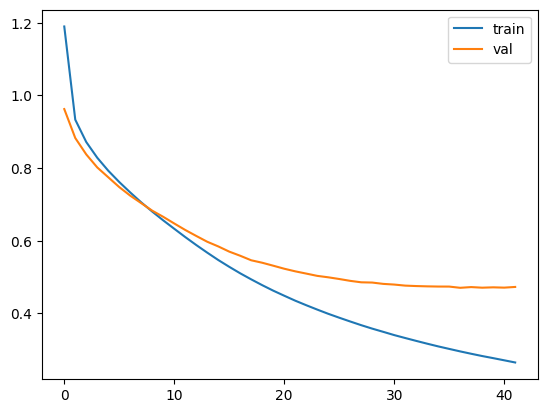

In [59]:
import matplotlib.pyplot as plt

plt.plot(train_loss_history, label="train")
plt.plot(val_loss_history, label="val")
plt.legend()
plt.show()

In [12]:
model = TransformerModel(config)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=0.01)
trainer = Trainer(config, model, train_dl, val_dl, test_dl, criterion, optimizer, src_tokenizer, tgt_tokenizer)


last_model_path = "/content/drive/MyDrive/Colab Notebooks/results/transformer-ko2eng/20240801144040/TransformerModel_ep_40_loss_0.2705_lr_0.0001.pt"
model.load_state_dict(torch.load(last_model_path))
model = model.to(config['device'])

trainer.test()

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:306: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
test :   0%|          | 0/326 [00:05<?, ?it/s]


input: 북한이 최근 군 수뇌부 3인방을 전면 교체한 것으로 전해졌다.
target: It has been reported that North Korea recently replaced three chief military leaders.
inference: It is heard that North Korea is leading the third place in the ruling party to the army.

input: 그가 장기적 타임 프레임보다 단기적 타임 프레임을 선호하는 이유다.
target: That ' s why he prefers short - term timeframes over long term timeframes.
inference: This is why he prefery short - term retirement that he is short - term than a short term.

input: 고승형의 가창력과 감정 표현은 이미 정평이 나있다.
target: Ko Seung - hyun ' s singing and expressing emotions are already well known.
inference: The passionate expression of the Dream trainer is already well - known.

input: 몸 상태가 온전하지 않아도 출전을 거르지 않는다.
target: Even if your body is not intact, do not go out.
inference: I don ' t have a hard time to play because my body is not in a physical condition.

input: 그는 이미 놀라운 회복력을 선보였던 전례가 있다.
target: He has a precedent that has already demonstrated incredible resilience.
inference: He has already b